# Explainable Artifical Intelligence (XAI) - Large Language Models 

___

**Introduction**


Machine learning (ML) systems are increasingly being integrated across various domains, from cars that drive themselves to smart assistants for improved user interactions. The widespread use of ML in complex applications has increased interest in creating systems that are not only high-performing but also safe, fair, and reliable. However, unlike straightforward performance metrics such as accuracy, these additional criteria are often challenging to quantify. For instance, it's difficult to list all necessary safety checks for a semi-autonomous vehicle or to fully ensure a credit scoring system is free from bias. In these situations, being able to understand how an ML system thinks becomes very important. If an ML system can explain its reasoning, we can then assess whether its logic aligns with these essential standards.

This is where Explainable AI (XAI) becomes invaluable. For data scientists and researchers, it's a tool to uncover biases and errors, to improve the system's performance and fairness. For end users and consumers, XAI fosters trust and acceptance by demystifying AI decisions, making them clear and understandable. The ability to peek under the hood of AI systems and understand their thought processes is a necessity, especially with privacy and transparency laws like GDPR highlighting the importance of clarity in AI-driven decisions. 

**Outline**

Note that captum distinguishes between perturbation based and gradient based

*Model Agnostic approaches:*
- SHAP
- LIME

*Model specific approaches:*
- Attention Maps
- Gradient based methods


**resources**
- Follow this tutorial, but use an opensource model from huggingface, perhaps phi-2? https://captum.ai/tutorials/Llama2_LLM_Attribution
- Using captum to explain LLM, metapaper: https://aclanthology.org/2023.nlposs-1.19.pdf
- LIME: https://captum.ai/tutorials/Image_and_Text_Classification_LIME
- Integrated gradients on sentiment analysis: https://captum.ai/tutorials/IMDB_TorchText_Interpret
- attribution based: https://captum.ai/tutorials/Llama2_LLM_Attribution
- Bert Q and 1: p1: https://captum.ai/tutorials/Bert_SQUAD_Interpret
- Bert Q&A:  p2” https://captum.ai/tutorials/Bert_SQUAD_Interpret2
- Shap: https://shap.readthedocs.io/en/latest/text_examples.html
- Lime and Shap visualization: https://github.com/enjakokalj/TransSHAP




# Note that captum contains shapleyvalue(Sampling), kernelshap and lime


In [ ]:
! pip install ipywidgets widgetsnbextension jupyter_contrib_nbextensions
! jupyter nbextension enable --py widgetsnbextension

# Load model

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# Set the seed for reproducibility
set_seed(42)

# Load the model and tokenizer
model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
def generate_text(model, tokenizer, prompt, max_new_tokens=20):
    """ Function to generate text based on a given prompt"""

    # Encode the input prompt
    tokens = tokenizer(prompt, return_tensors="pt")

    # Generate a sequence of tokens following the input
    output = model.generate(**tokens, max_new_tokens=max_new_tokens, use_cache=True)

    # Decode the generated tokens to a readable format
    # generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_text = tokenizer.batch_decode(output)[0]

    return generated_text

# Generate text based on a prompt
prompt = "XAI is important for users because"
# prompt = "Understanding how an AI model makes a decision is important because "
completed_text = generate_text(model, tokenizer, prompt, max_new_tokens=20)
print(completed_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


XAI is important for users because it helps them understand how their data is being used and gives them control over their privacy.




## Feature Ablation

The API provides flexibility to define units of
attribution as custom interpretable features which
could be individual words, tokens, phrases, or even
full sentences. For example, in Figure 2, we select
the relevant features to be the name, city, state,
occupation, and pronoun in the sentence prompt
and desire to determine the relative contribution of
these contextual features on the model’s predicted
sentence completion.
Users can define the units for attribution as a list
or dictionary of features and provide a format string
or function to define a mapping from the attribution
units to the full input prompt as shown in Figure 3.

The baseline choice is particularly important for
computing attribution for text features, as it serves
as the reference value used when perturbing the
chosen feature. The perturbation-based feature API
allows defining custom baselines corresponding to each input feature.
It is recommended to select a baseline which fits
the context of the original text and remains within
the natural data distribution. For example, replacing the name of a city with another city ensures
the sentence remains naturally coherent, but allows
measuring the contribution of the particular city
selected.



In [14]:
# TODO: check which are used
from captum.attr import (
    FeatureAblation, 
    ShapleyValues,
    LayerIntegratedGradients, 
    LLMAttribution, 
    LLMGradientAttribution, 
    TextTokenInput, 
    TextTemplateInput,
    ProductBaselines,
)

In [22]:
feature_ablation = FeatureAblation(model)
llm_attr = LLMAttribution(feature_ablation, tokenizer)

In [38]:
tokens = tokenizer.tokenize(prompt)

# Print each token with its corresponding index
for i, token in enumerate(tokens):
    print(f"Index: {i}, Token: {token}")


Index: 0, Token: X
Index: 1, Token: AI
Index: 2, Token: Ġis
Index: 3, Token: Ġimportant
Index: 4, Token: Ġfor
Index: 5, Token: Ġusers
Index: 6, Token: Ġbecause


In [37]:
inp = TextTokenInput(
    prompt, 
    tokenizer,
)

target = "it helps them understand how their data is being used and gives them control over their privacy."

attr_res = llm_attr.attribute(inp, target=target)

In [32]:
# Todo: check what below entails
print("attr to the output sequence:", attr_res.seq_attr.shape)  # shape(n_input_token)
print("attr to the output tokens:", attr_res.token_attr.shape)  # shape(n_output_token, n_input_token)

attr to the output sequence: torch.Size([3])
attr to the output tokens: torch.Size([14, 3])


The character `Ġ` is used in tokenization to indicate the start of a new word, distinguishing it from continuations of previous words or subword units.

The return contains the attribution tensors to both the entire generated target seqeuence and each generated token, which tell us how each input token impact the output and each token within it.



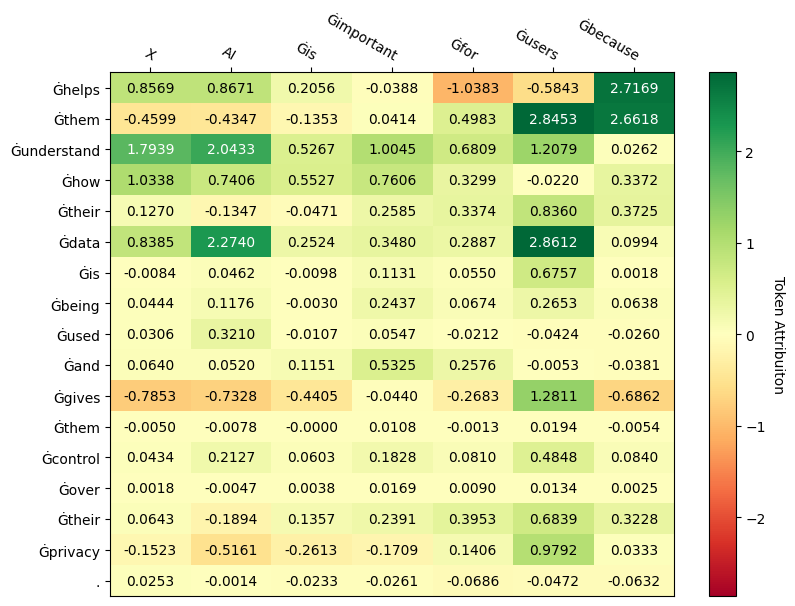

In [39]:
attr_res.plot_token_attr(show=True)



However, it may not always make sense to define individual token as intepretable features and perturb it. Tokenizers used in modern LLMs may break a single word making the tokens not intepretable by themselves. 


For example, in our case above, the tokenizer can break the word "XAI" into "X" and "AI". It doesn't make much sense to study the separate attribution of them. Moreover, even a whole word can be meaningless. For example, "the Netherlands" together result in a country name. Changing just partial of its tokens would likely not give anything belongs to the natural distribution which may lead to unexpected impacts on the perturbed model output. -> to rewrite


In [ ]:
# inp = TextTemplateInput(
#     template="{} lives in {}, {} and is a {}. {} personal interests include", 
#     values=["Dave", "Palm Coast", "FL", "lawyer", "His"],
# )

# target = "playing golf, hiking, and cooking."

# attr_res = llm_attr.attribute(inp, target=target)

# attr_res.plot_token_attr(show=True)

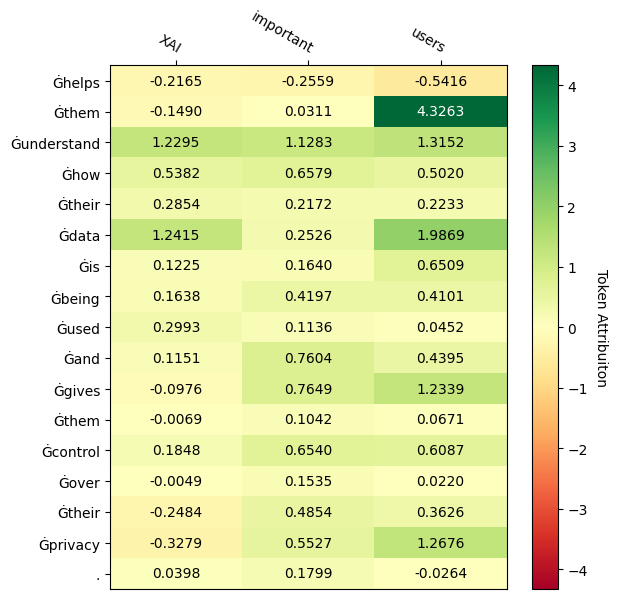

In [41]:
inp = TextTemplateInput(
    template="{} is {} for {} because", 
    values=["XAI", "important", "users"],
)

target = "it helps them understand how their data is being used and gives them control over their privacy."

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)

We know that perturbation-based algrotihms calculate the attribution by switching the features between "presence" and "absence" states. So what should a text feature look like here when it is in "absence" in the above example? Captum allows users to set the baselines, i.e., the reference values, to use when a feature is absent. By default, TextTemplateInput uses empty string '' as the baselines for all, which is equivalent to the removal of the segments. This may not be perfect for the same out-of-distribution reason. For example, when the feature "name" is absent, the prompt loses its subjective and no longer makes much sense.

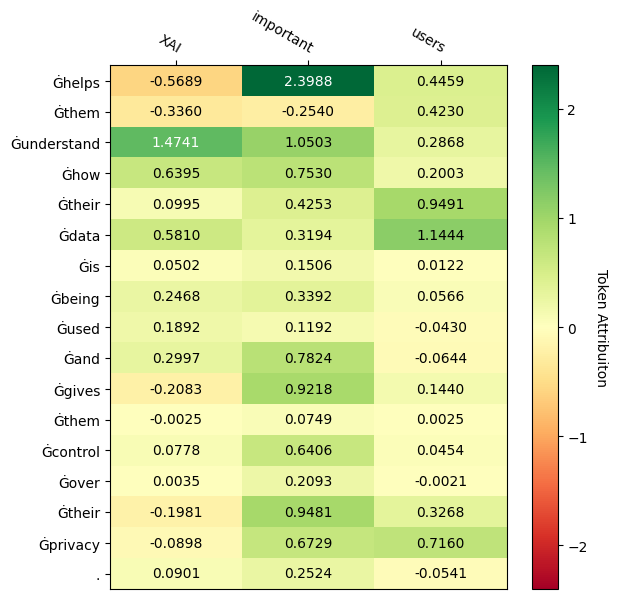

In [45]:
inp = TextTemplateInput(
    template="{} is {} for {} because", 
    values=["XAI", "important", "users"],
    baselines=["AI", "trivial", "people"],
)

target = "it helps them understand how their data is being used and gives them control over their privacy."

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)

One potential issue with the current approach is using Feature Ablation. If the model learns complex interations between the prompt features, the true importance may not be reflected in the attribution scores. Consider a case where the model predicts a high probability of playing golf if a person is either a lawyer or lives in Palm Coast. By ablating a feature one at a time, the probability may appear to be unchanged when ablating each feature independently, but may drop substantially when perturbing both together.

To address this, we can apply alternate perturbation-based attribution methods available in Captum such as ShapleyValue(Sampling), KernelShap and Lime, which ablate different subgroups of features and may result in more accurate scores.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


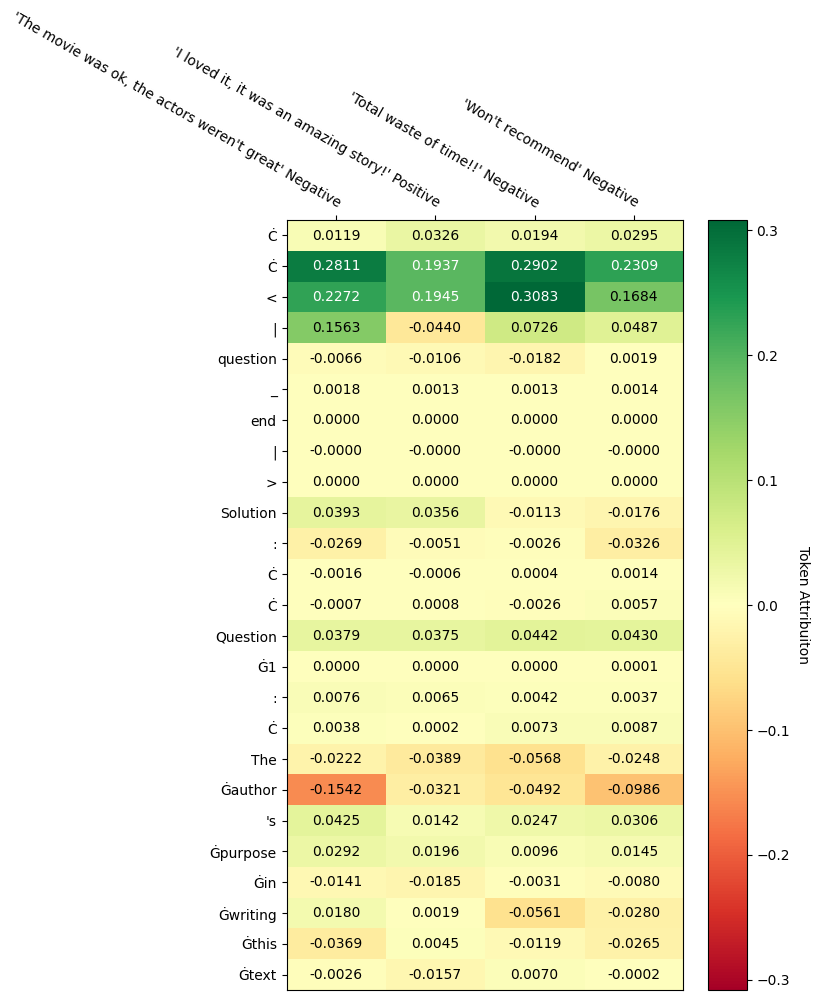

In [47]:
def prompt_fn(*examples):
    main_prompt = "Decide if the following movie review enclosed in quotes is Positive or Negative:\n'I really liked the Avengers, it had a captivating plot!'\nReply only Positive or Negative."
    subset = [elem for elem in examples if elem]
    if not subset:
        prompt = main_prompt
    else:
        prefix = "Here are some examples of movie reviews and classification of whether they were Positive or Negative:\n"
        prompt = prefix + " \n".join(subset) + "\n " + main_prompt
    return "[INST] " + prompt + "[/INST]" # TODO: change this to phi template

input_examples = [
    "'The movie was ok, the actors weren't great' Negative", 
    "'I loved it, it was an amazing story!' Positive",
    "'Total waste of time!!' Negative", 
    "'Won't recommend' Negative",
]
inp = TextTemplateInput(
    prompt_fn, 
    values=input_examples,
)

attr_res = sv_llm_attr.attribute(inp)

attr_res.plot_token_attr(show=True)

In [53]:
! pip install inseq


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Ignored the following versions that require a different python version: 0.3.1 Requires-Python >=3.8.1,<3.12; 0.3.2 Requires-Python >=3.8.1,<3.12; 0.3.3 Requires-Python >=3.8.1,<3.12; 0.4.0 Requires-Python >=3.8.1,<3.12; 0.5.0 Requires-Python >=3.9,<3.12
ERROR: Could not find a version that satisfies the requirement inseq (from versions: none)
ERROR: No matching distribution found for inseq


In [ ]:
! 